# Autoencoder


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Data Normalization

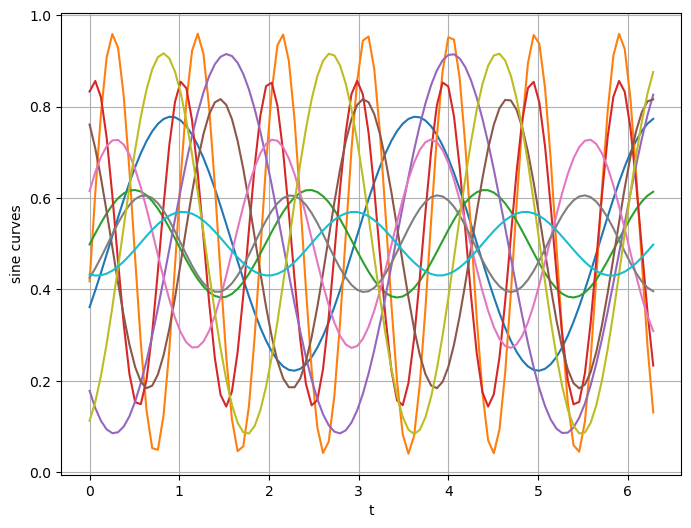

Training Data Min: 0.001371866819443124, Max: 0.9988453225889077
Validation Data Min: 0.00034984558249327605, Max: 0.9998263091570978
Target Data Min: 0.0, Max: 1.0


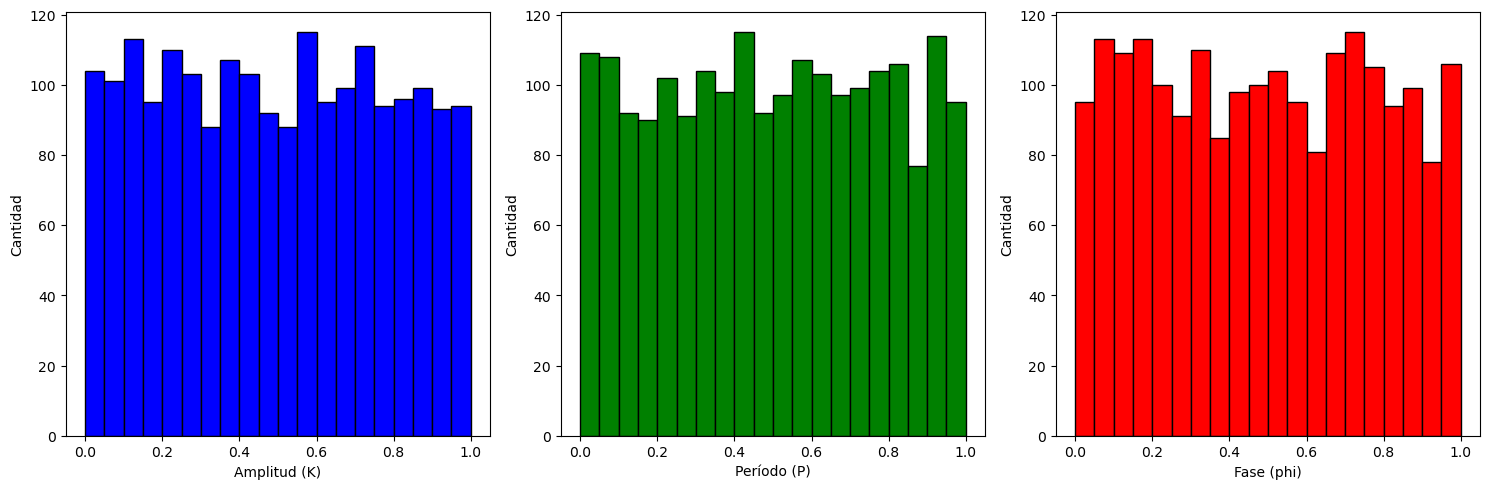

In [ ]:
data = np.loadtxt("Sinusoid_ML.dat")
P, K, phi = data[:, 0], data[:, 1], data[:, 2]


t = np.linspace(0, 2 * np.pi, 100)
#sine_curves = np.array([K[i] * np.sin(2 * np.pi * t / P[i] + 0) for i in range(len(P))])
sine_curves = data[:,3:103]
sine_curves = (sine_curves - sine_curves.min()) / (sine_curves.max() - sine_curves.min())

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(t, sine_curves[i], label=f'Curve {i+1}')

plt.xlabel("t")
plt.ylabel("sine curves")
plt.grid()
plt.show()


P_norm = (P - P.min()) / (P.max() - P.min())
K_norm = (K - K.min()) / (K.max() - K.min())
phi_norm = (phi - phi.min()) / (phi.max() - phi.min())
#phi_norm[:]=0


target_params = np.vstack([K_norm, P_norm, phi_norm]).T # transposta: cada fila 3 parametres

# 70% train, 15% val, 15% test
sine_train, sine_temp, target_train, target_temp = train_test_split(sine_curves, target_params, test_size=0.3, random_state=26)
sine_val, sine_test, target_val, target_test = train_test_split(sine_temp, target_temp, test_size=0.5, random_state=26)

print(f"Training Data Min: {sine_train.min()}, Max: {sine_train.max()}")
print(f"Validation Data Min: {sine_val.min()}, Max: {sine_val.max()}")
print(f"Target Data Min: {target_train.min()}, Max: {target_train.max()}")


#sine_train = torch.tensor(sine_train, dtype=torch.float32)
sine_train = torch.tensor(sine_train, dtype=torch.float32).reshape(-1, 1, 100)
#sine_val = torch.tensor(sine_val, dtype=torch.float32)
sine_val = torch.tensor(sine_val, dtype=torch.float32).reshape(-1, 1, 100)
# sine_test = torch.tensor(sine_test, dtype=torch.float32)
sine_test = torch.tensor(sine_test, dtype=torch.float32).reshape(-1, 1, 100)
target_train = torch.tensor(target_train, dtype=torch.float32)
target_val = torch.tensor(target_val, dtype=torch.float32)
target_test = torch.tensor(target_test, dtype=torch.float32)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(K_norm, bins=20, color='b', edgecolor='black')
plt.xlabel('Amplitud (K)')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 2)
plt.hist(P_norm, bins=20, color='g', edgecolor='black')
plt.xlabel('Período (P)')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 3)
plt.hist(phi_norm, bins=20, color='r', edgecolor='black')
plt.xlabel('Fase (phi)')
plt.ylabel('Cantidad')


plt.tight_layout()
plt.show()

### Testing the AE model

#### Training and Validation set

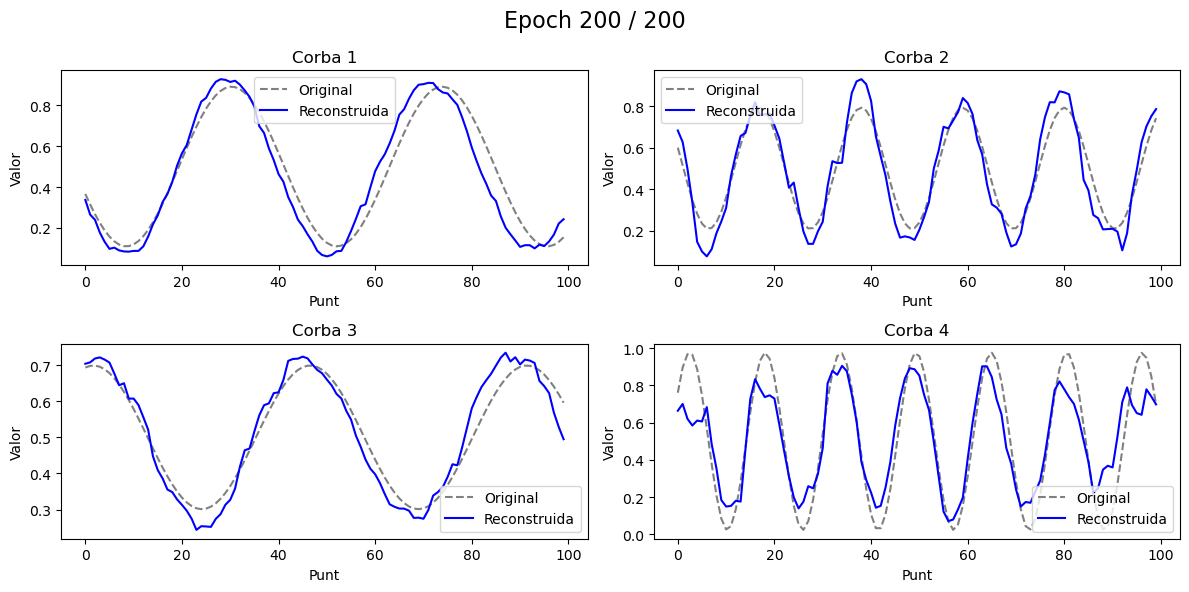

Epoch [0/200], Train Loss: 0.045953, Val Loss: 0.045133
Epoch [10/200], Train Loss: 0.023139, Val Loss: 0.023184
Epoch [20/200], Train Loss: 0.016482, Val Loss: 0.017589
Epoch [30/200], Train Loss: 0.015113, Val Loss: 0.015735
Epoch [40/200], Train Loss: 0.013563, Val Loss: 0.015611
Epoch [50/200], Train Loss: 0.012583, Val Loss: 0.014482
Epoch [60/200], Train Loss: 0.011641, Val Loss: 0.014588
Epoch [70/200], Train Loss: 0.010396, Val Loss: 0.014111
Epoch [80/200], Train Loss: 0.010443, Val Loss: 0.013721
Epoch [90/200], Train Loss: 0.010494, Val Loss: 0.013231
Epoch [100/200], Train Loss: 0.009915, Val Loss: 0.012813
Epoch [110/200], Train Loss: 0.009689, Val Loss: 0.012328
Epoch [120/200], Train Loss: 0.009500, Val Loss: 0.013440
Epoch [130/200], Train Loss: 0.010372, Val Loss: 0.013951
Epoch [140/200], Train Loss: 0.009138, Val Loss: 0.015457
Epoch [150/200], Train Loss: 0.009042, Val Loss: 0.012756
Epoch [160/200], Train Loss: 0.008316, Val Loss: 0.013446
Epoch [170/200], Train Lo

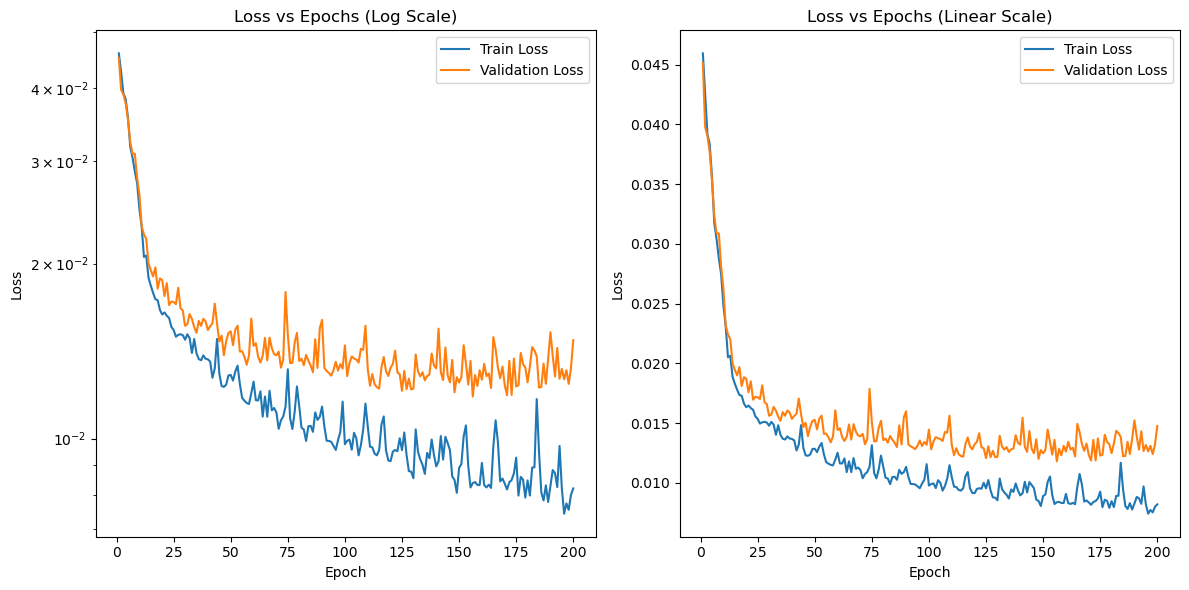

In [47]:
# MODEL TESTING

class AEConv(nn.Module):
    def __init__(self):
        super(AEConv, self).__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=4, out_channels=12, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(12 * 100, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Tanh()
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 12 * 100),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (12, 100))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=12, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        return x, z



# Crear el modelo
model = AEConv()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
num_epochs = 200
batch_size = 16
dataset = torch.utils.data.TensorDataset(sine_train, target_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(sine_val, target_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_losses = []
val_losses = []

log_messages = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs, latent = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * batch_x.size(0)
    

    avg_train_loss = running_train_loss / len(dataloader.dataset)
    train_losses.append(avg_train_loss)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_x, val_y in val_dataloader:
            val_outputs, latent = model(val_x)
            val_loss = criterion(val_outputs, val_x)
            running_val_loss += val_loss.item() * val_x.size(0)
    
    avg_val_loss = running_val_loss / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)

    with torch.no_grad():
        reconstructed, latent = model(sine_test)
    reconstructed = reconstructed.numpy()
    latent = latent.numpy()
    all_predictions.append(reconstructed)
    
    # plot (animacion a partir de aqui)
    # Actualitzar gràfic en viu dins del notebook
    clear_output(wait=True)
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))

    axes = axes.flatten()
    for i in range(4):
        axes[i].plot(sine_test[i][0].numpy(), label='Original', color='gray', linestyle='--')
        axes[i].plot(reconstructed[i][0], label='Reconstruida', color='blue')
        axes[i].set_title(f'Corba {i+1}')
        axes[i].set_xlabel('Punt')
        axes[i].set_ylabel('Valor')
        axes[i].legend()
    fig.suptitle(f"Epoch {epoch+1} / {num_epochs}", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    if epoch % 10 == 0:
        log = f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}"
        log_messages.append(log)

    # Mostrar els logs acumulats
    for log in log_messages:
        print(log)
        
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Log scale
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Log Scale)")
plt.legend()

# Linear scale
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Linear Scale)")
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluation set

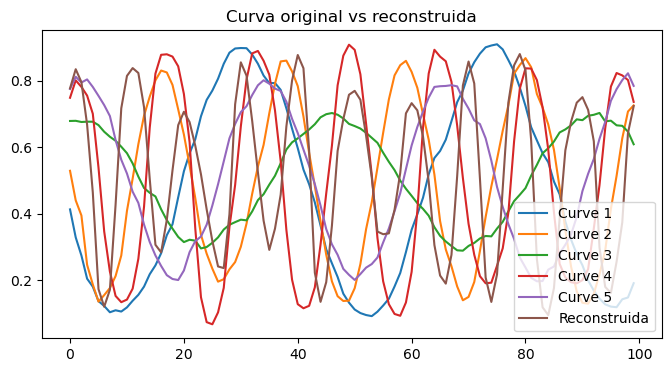

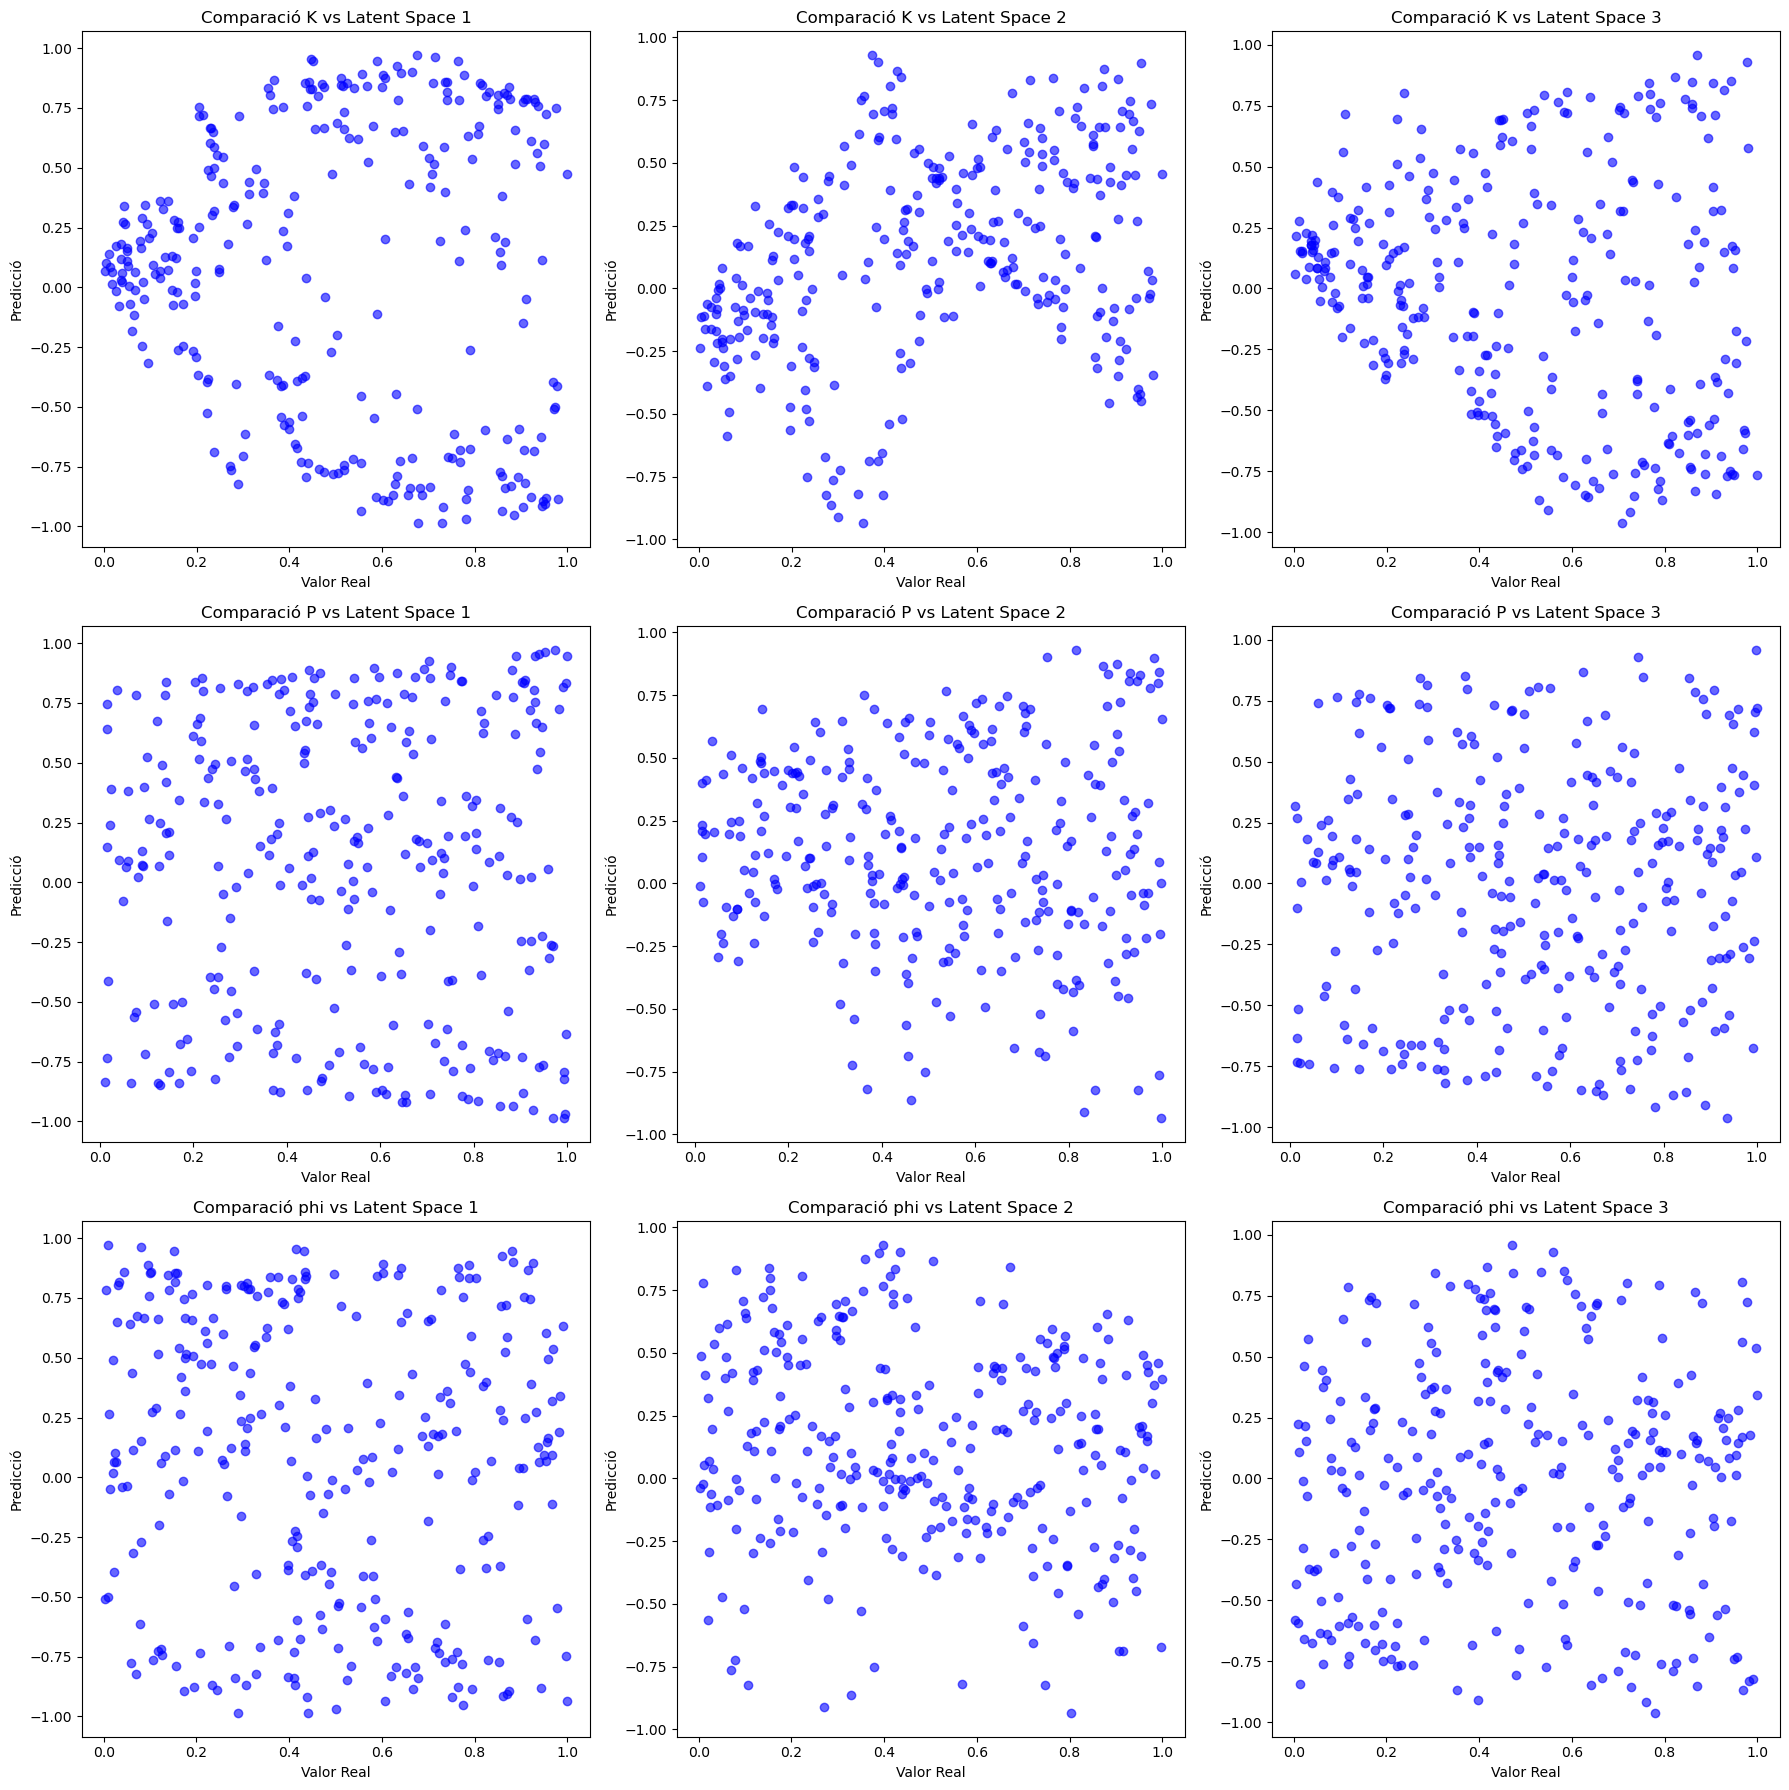

In [10]:
# evaluation
model.eval()
with torch.no_grad():
    reconstructed, predict = model(sine_test)


reconstructed = reconstructed.numpy()
predict = predict.numpy()
params = target_test.numpy()


# plot curves

# Comprovació d'una corba concreta
idx = 144

plt.figure(figsize=(8,4))
for i in range(5):
    #plt.plot(sine_test[i].numpy()[0], label=f'Curve {i+1}')
    plt.plot(reconstructed[i][0], label=f'Curve {i+1}')
#plt.plot(sine_test[idx].numpy()[0], label='Original')      # [0] per eliminar la dimensió de canal
plt.plot(reconstructed[idx][0], label='Reconstruida')      # idem
plt.legend()
plt.title("Curva original vs reconstruida")
plt.show()

# plot

parametres = ['K','P','phi']
plt.figure(figsize=(18, 18))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3+j+1)
        plt.scatter(params[:, i], predict[:, j], color='blue', alpha=0.6)
        plt.title(f'Comparació {parametres[i]} vs Latent Space {j+1}')
        plt.xlabel("Valor Real")
        plt.ylabel("Predicció")

plt.tight_layout()
plt.savefig('plot.png')
plt.show()


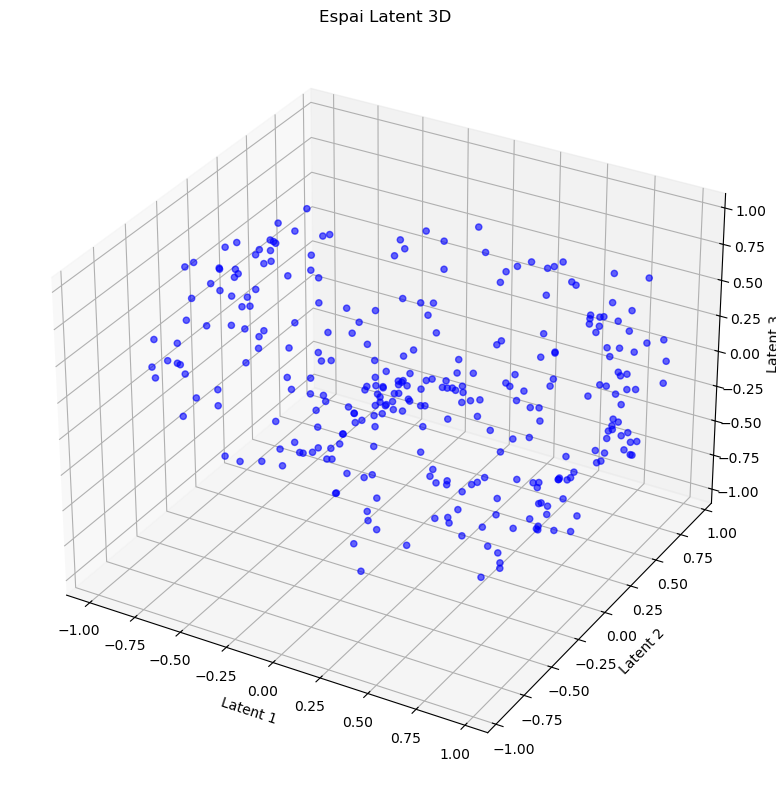

In [12]:
# Crear figura i eixos 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
ax.scatter(predict[:, 0], predict[:, 1], predict[:, 2], c='blue', alpha=0.6)

# Etiquetes
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.set_zlabel('Latent 3')
ax.set_title('Espai Latent 3D')

plt.tight_layout()
plt.show()


### Final AE model

#### Training for 30000 Epochs

In [16]:
# MODEL BEST TRY

class AEConv(nn.Module):
    def __init__(self):
        super(AEConv, self).__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=4, out_channels=12, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(12 * 100, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Tanh()
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 12 * 100),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (12, 100))
        
        self.decoder_conv = nn.Sequential(
        nn.Conv1d(in_channels=12, out_channels=4, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv1d(in_channels=4, out_channels=1, kernel_size=3, padding=1),
                    nn.Sigmoid()
                )
        
    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        return x, z

        
        
# Crear el modelo
model = AEConv()
lr=0.0007
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 30000
batch_size = 32
dataset = torch.utils.data.TensorDataset(sine_train, target_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_losses = []


for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs, latent = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * batch_x.size(0)
        
    
    avg_train_loss = running_train_loss / len(dataloader.dataset)
    train_losses.append(avg_train_loss)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}")



Epoch [0/30000], Train Loss: 0.045877
Epoch [10/30000], Train Loss: 0.030055
Epoch [20/30000], Train Loss: 0.022709
Epoch [30/30000], Train Loss: 0.019668
Epoch [40/30000], Train Loss: 0.017682
Epoch [50/30000], Train Loss: 0.016261
Epoch [60/30000], Train Loss: 0.014971
Epoch [70/30000], Train Loss: 0.013552
Epoch [80/30000], Train Loss: 0.012326
Epoch [90/30000], Train Loss: 0.011509
Epoch [100/30000], Train Loss: 0.010868
Epoch [110/30000], Train Loss: 0.010201
Epoch [120/30000], Train Loss: 0.009664
Epoch [130/30000], Train Loss: 0.009372
Epoch [140/30000], Train Loss: 0.009069
Epoch [150/30000], Train Loss: 0.008570
Epoch [160/30000], Train Loss: 0.008261
Epoch [170/30000], Train Loss: 0.008049
Epoch [180/30000], Train Loss: 0.007621
Epoch [190/30000], Train Loss: 0.007427
Epoch [200/30000], Train Loss: 0.007251
Epoch [210/30000], Train Loss: 0.007129
Epoch [220/30000], Train Loss: 0.006904
Epoch [230/30000], Train Loss: 0.006708
Epoch [240/30000], Train Loss: 0.006560
Epoch [250/

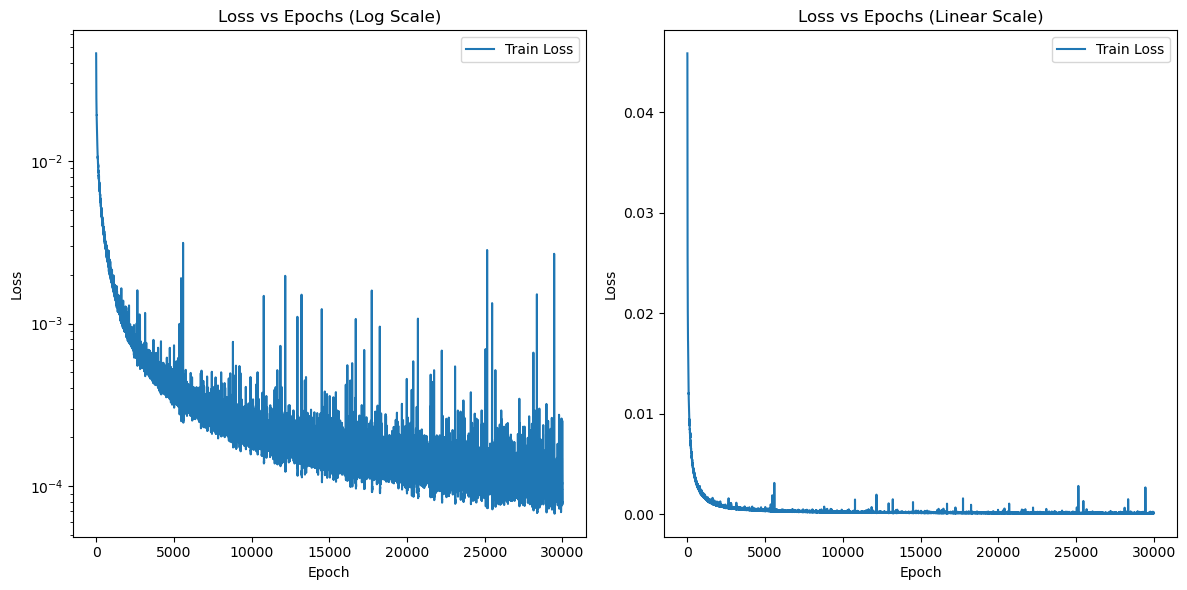

In [18]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Log scale
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Log Scale)")
plt.legend()

# Linear scale
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Linear Scale)")
plt.legend()

plt.tight_layout()
plt.show()